## Tutorial: Exploratory Data Analysis

### University of California, Santa Barbara  
### PSTAT 135/235  
### Last Updated: Oct 22, 2018

---  

### Sources 

Learning PySpark, Chapter 4

https://www.analyticsvidhya.com/blog/2016/10/spark-dataframe-and-operations/

### OBJECTIVES
- Introduction to methods for EDA

### PREREQUISITES
- RDDs
- Spark DataFrames
- Schemas
- matplotlib

---  

In [1]:
import os
import pyspark.sql.types as typ
import pyspark.sql.functions as F

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("data preprocessing") \
    .config("spark.executor.memory", '8g') \
    .config('spark.executor.cores', '4') \
    .config('spark.cores.max', '4') \
    .config("spark.driver.memory",'8g') \
    .getOrCreate()

sc = spark.sparkContext

In [3]:
sc.getConf().getAll()

[('spark.master', 'local'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'data preprocessing'),
 ('spark.driver.host', 'jupyter-adamtashman314'),
 ('spark.executor.cores', '4'),
 ('spark.cores.max', '4'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.memory', '8g'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.memory', '8g'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1544634897412'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '34375')]

In [4]:
path_to_data = os.path.join('/home/jovyan/UCSB_BigDataAnalytics/data/fraud/ccFraud.csv.gz')

In [5]:
# read in data; notice we can directly read zipped csv format
fraud = sc.textFile(path_to_data)

In [6]:
header = fraud.first()

In [7]:
fraud = fraud \
        .filter(lambda row: row != header) \
        .map(lambda row: [int(elem) for elem in row.split(',')])

#### Create a schema to pass to a Spark dF

In [8]:
fields = [
    *[
        typ.StructField(h[1:-1], typ.IntegerType(), True)
        for h in header.split(',')
    ]
]

note: h[1:-1] indexing strips quotes from field names

In [9]:
schema = typ.StructType(fields)

In [10]:
fraud_df = spark.createDataFrame(fraud, schema)

In [11]:
# cache the table as we will use it many times
fraud_df.cache()

DataFrame[custID: int, gender: int, state: int, cardholder: int, balance: int, numTrans: int, numIntlTrans: int, creditLine: int, fraudRisk: int]

In [12]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



### Data Summary

In [18]:
fraud_df.describe(['balance','numTrans','creditLine']).show()

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|       creditLine|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        9.1344691|
| stddev|3996.847309737077|26.553781024522852|9.641973639142257|
|    min|                0|                 0|                1|
|    max|            41485|               100|               75|
+-------+-----------------+------------------+-----------------+



In [25]:
fraud_df.agg({'balance' : 'kurtosis'}).show()

+-----------------+
|kurtosis(balance)|
+-----------------+
|1.826501325798854|
+-----------------+



#### Compute correlation

In [26]:
# compute between one possible pair 
fraud_df.corr('balance','numTrans')

0.00044523140172659576

In [34]:
# compute correlation between all numeric features
features_numeric = ['balance','numTrans','numIntlTrans','creditLine']

n_numeric = len(features_numeric)
corr = []

for i in range(0, n_numeric):
 temp = [None] * i

 for j in range(i, n_numeric):
     temp.append(fraud_df.corr(features_numeric[i], features_numeric[j]))
 corr.append(temp)

In [35]:
corr

[[1.0, 0.00044523140172659576, 0.00027139913398184604, 0.26358312865961103],
 [None, 1.0, -0.0002805712819816179, 0.0003172509810506346],
 [None, None, 1.0, -0.00027936340386579294],
 [None, None, None, 1.0]]

### Visualization

#### Show histogram of BALANCE as an example

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [52]:
# first aggregate the data into bins, then plot

hists = fraud_df.select('balance').rdd.flatMap(lambda row: row) \
        .histogram(20)

In [51]:
# show the frequencies
hists[1]

[3640021,
 2258778,
 1718633,
 1035019,
 601524,
 343461,
 192766,
 104486,
 54517,
 27570,
 13117,
 5805,
 2650,
 1103,
 358,
 127,
 45,
 15,
 1,
 4]

Text(0.5, 1.0, "Histogram of 'balance'")

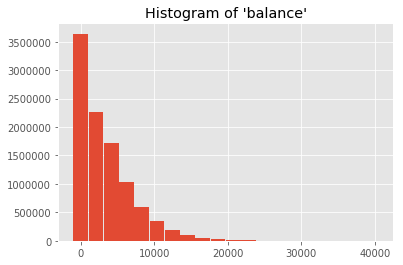

In [53]:
data = {
 'bins': hists[0][:-1],
 'freq': hists[1]
}

plt.bar(data['bins'], data['freq'], width=2000)
plt.title('Histogram of \'balance\'')

#### Scatter plots  
Note: the data are sampled to minimize runtime. Use various seeds to assert samples are representative.

In [55]:
# sample 0.02% of data

data_sample = fraud_df.sampleBy(
 'gender', {1: 0.0002, 2: 0.0002}
).select(features_numeric)

In [56]:
data_sample.count()

2056

In [63]:
data_multi = dict([
 (elem, data_sample.select(elem).rdd.flatMap(lambda row: row).collect())
 for elem in features_numeric
])

In [64]:
data_multi

{'balance': [0,
  11000,
  3535,
  0,
  0,
  10000,
  3000,
  3000,
  8000,
  3000,
  5000,
  0,
  2529,
  366,
  0,
  9310,
  0,
  6000,
  3000,
  15378,
  702,
  0,
  4418,
  8000,
  0,
  6604,
  0,
  0,
  4000,
  0,
  0,
  1781,
  0,
  5000,
  0,
  0,
  7000,
  6875,
  0,
  9000,
  0,
  0,
  4718,
  6000,
  30,
  0,
  0,
  8112,
  0,
  3807,
  6000,
  16220,
  4000,
  0,
  5463,
  3000,
  0,
  0,
  0,
  10819,
  9455,
  0,
  15428,
  1590,
  0,
  2393,
  4000,
  6000,
  6841,
  0,
  0,
  0,
  0,
  15954,
  11000,
  4000,
  9000,
  0,
  4000,
  0,
  0,
  0,
  5000,
  6000,
  12000,
  0,
  0,
  13000,
  3000,
  4071,
  1718,
  12003,
  0,
  0,
  0,
  5000,
  1366,
  3000,
  0,
  0,
  9000,
  0,
  4000,
  0,
  0,
  0,
  9215,
  11962,
  4000,
  3000,
  6000,
  5000,
  0,
  5202,
  0,
  9000,
  7401,
  5000,
  3543,
  8000,
  4000,
  4000,
  0,
  12456,
  473,
  8000,
  0,
  4000,
  8369,
  4116,
  7000,
  9000,
  6000,
  10473,
  1087,
  0,
  4450,
  0,
  5000,
  8000,
  1504,
  4503,


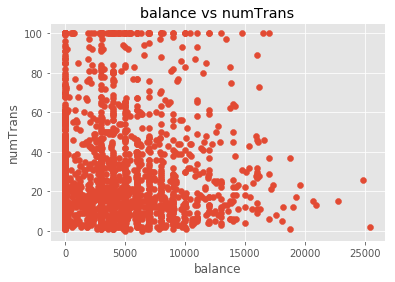

In [69]:
plt.scatter(x=data_multi['balance'], y=data_multi['numTrans'])
plt.xlabel('balance')
plt.ylabel('numTrans')
plt.title('balance vs numTrans')
plt.show()